In [23]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cpu


In [24]:
def load_json_files():
    """Load dataset from local JSON files"""
    try:
        with open('train.json', 'r', encoding='utf-8') as f:
            train_data = json.load(f)
        with open('dev.json', 'r', encoding='utf-8') as f:
            dev_data = json.load(f)
        with open('test.json', 'r', encoding='utf-8') as f:
            test_data = json.load(f)
        
        print(f" Dataset sizes:")
        print(f"Train: {len(train_data)} | Dev: {len(dev_data)} | Test: {len(test_data)}")
        return train_data, dev_data, test_data
        
    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print("Please make sure train.json, dev.json, test.json are in the same folder")
        return None, None, None

In [25]:
def extract_features_v3(user):
    profile = user.get('profile', {}) or {}

    def safe_num(x, default=0):
        try: return float(str(x).strip())
        except: return default

    # Counts
    followers = safe_num(profile.get('followers_count', 0))
    friends = safe_num(profile.get('friends_count', 0))
    statuses = safe_num(profile.get('statuses_count', 0))
    favourites = safe_num(profile.get('favourites_count', 0))
    listed = safe_num(profile.get('listed_count', 0))

    # Boolean
    verified = 1 if str(profile.get('verified')).lower() == 'true' else 0
    default_prof = 1 if str(profile.get('default_profile')).lower() == 'true' else 0
    default_img = 1 if str(profile.get('default_profile_image')).lower() == 'true' else 0
    geo_enabled = 1 if str(profile.get('geo_enabled')).lower() == 'true' else 0

    # Critical ratios
    fr_ratio = friends / (followers + 1)
    fl_ratio = followers / (friends + 1)
    tweets_per_day = statuses / max(followers + friends + 1, 1)
    favourites_ratio = favourites / (statuses + 1)
    listed_ratio = listed / (followers + 1)

    # Text info
    desc = str(profile.get('description', ''))
    name = str(profile.get('name', ''))
    screen_name = str(profile.get('screen_name', ''))
    has_url = 1 if profile.get('url') and str(profile.get('url')).strip() else 0

    # Tweets
    tweets = user.get('tweet') or []
    num_tweets = len([t for t in tweets if isinstance(t, str)])

    if num_tweets > 0:
        tweet_lens = [len(str(t)) for t in tweets if isinstance(t, str)]
        avg_len = np.mean(tweet_lens)
        url_count = sum(str(t).count('http') for t in tweets if isinstance(t, str))
        mention_count = sum(str(t).count('@') for t in tweets if isinstance(t, str))
        hashtag_count = sum(str(t).count('#') for t in tweets if isinstance(t, str))
        rt_count = sum(1 for t in tweets if isinstance(t, str) and str(t).startswith('RT @'))
        urls_per_tweet = url_count / num_tweets
        mentions_per_tweet = mention_count / num_tweets
        hashtags_per_tweet = hashtag_count / num_tweets
        retweet_ratio = rt_count / num_tweets
    else:
        avg_len = urls_per_tweet = mentions_per_tweet = hashtags_per_tweet = retweet_ratio = 0

    # Activity features
    recent_activity = np.log1p(num_tweets)

    features = [
        np.log1p(followers), np.log1p(friends), np.log1p(statuses), np.log1p(favourites), np.log1p(listed),
        fr_ratio, fl_ratio, tweets_per_day, favourites_ratio, listed_ratio,
        verified, default_prof, default_img, geo_enabled, has_url,
        len(desc), len(name), len(screen_name),
        num_tweets, avg_len,
        urls_per_tweet, mentions_per_tweet, hashtags_per_tweet, retweet_ratio,
        recent_activity
    ]

    return features

In [26]:
def prepare_data_v3(data_list):
    X, y, ids = [], [], []
    for user in data_list:
        X.append(extract_features_v3(user))
        y.append(int(user.get('label', 0)))
        ids.append(user.get('ID', ''))

    X = np.nan_to_num(np.array(X, dtype=np.float32), nan=0.0, posinf=1e6, neginf=-1e6)
    y = np.array(y, dtype=np.int64)
    return X, y, ids

# 🕸️ Graph Building (Your Original Code)
def build_graph_v3(data_list, X_features, k=20):
    G = nx.Graph()
    screen_to_idx = {}

    # Nodes
    for i, user in enumerate(data_list):
        name = str(user.get('profile', {}).get('screen_name', '')).lower().strip()
        if name:
            screen_to_idx[name] = i
        G.add_node(i)

    edges = {'mention':0, 'knn':0}

    # Mention edges
    for i, user in enumerate(data_list):
        tweets = user.get('tweet') or []
        for tweet in tweets:
            if not isinstance(tweet, str): continue
            for word in str(tweet).split():
                if word.startswith('@'):
                    target = word[1:].strip('.:,;!?\'"()').lower()
                    if target in screen_to_idx:
                        j = screen_to_idx[target]
                        if i != j:
                            G.add_edge(i, j)
                            edges['mention'] +=1

    # K-NN behavioral similarity
    knn = NearestNeighbors(n_neighbors=min(k+1,len(data_list)), metric='cosine')
    knn.fit(X_features)
    distances, indices = knn.kneighbors(X_features)

    for i in range(len(data_list)):
        for idx, j in enumerate(indices[i][1:]):  # skip self
            if i != j and not G.has_edge(i,j):
                sim = 1 - distances[i][idx+1]
                if sim > 0.75:
                    G.add_edge(i,j)
                    edges['knn'] += 1

    print(f"Graph nodes: {G.number_of_nodes()} | edges: {G.number_of_edges()}")
    print(f"Mentions: {edges['mention']} | K-NN: {edges['knn']} | Avg degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")
    return G

def nx_to_pyg(graph, features, labels):
    """Convert NetworkX graph to PyTorch Geometric format"""
    edge_index = torch.tensor(list(graph.edges())).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

In [27]:
class BotDetectorGNN_v2(torch.nn.Module):
    def __init__(self, in_channels, hidden1=128, hidden2=64):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden1)
        self.conv2 = SAGEConv(hidden1, hidden2)
        self.conv3 = SAGEConv(hidden2, 2)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


In [28]:
# 📊 COMPREHENSIVE ANALYSIS FUNCTIONS
def plot_training_history(train_losses, test_accuracies):
    """Plot training loss and test accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Accuracy plot
    ax2.plot(test_accuracies, 'g-', linewidth=2, label='Test Accuracy')
    ax2.set_title('Test Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot detailed confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'Bot'], 
                yticklabels=['Human', 'Bot'],
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Confusion Matrix - Fake Profile Detection', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.show()

def plot_feature_importance_analysis(X_train, y_train):
    """Basic feature importance analysis"""
    from sklearn.ensemble import RandomForestClassifier
    
    # Train a Random Forest to get feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Create feature names
    feature_names = [
        'log_followers', 'log_friends', 'log_statuses', 'log_favourites', 'log_listed',
        'fr_ratio', 'fl_ratio', 'tweets_per_day', 'favourites_ratio', 'listed_ratio',
        'verified', 'default_profile', 'default_image', 'geo_enabled', 'has_url',
        'desc_len', 'name_len', 'screen_name_len',
        'num_tweets', 'avg_tweet_len',
        'urls_per_tweet', 'mentions_per_tweet', 'hashtags_per_tweet', 'retweet_ratio',
        'recent_activity'
    ]
    
    # Plot top 15 features
    indices = np.argsort(importance)[::-1][:15]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(indices)), importance[indices], color='skyblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features for Bot Detection')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for bar, value in zip(bars, importance[indices]):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_class_distribution(y_train, y_test):
    """Plot class distribution in train and test sets"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Train distribution
    train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
    ax1.pie(train_counts, labels=['Human', 'Bot'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    ax1.set_title('Training Set Distribution')
    
    # Test distribution
    test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]
    ax2.pie(test_counts, labels=['Human', 'Bot'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    ax2.set_title('Test Set Distribution')
    
    plt.tight_layout()
    plt.show()

def plot_performance_comparison(metrics_dict):
    """Plot performance metrics comparison"""
    metrics = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def print_detailed_analysis(y_true, y_pred, train_data, test_data):
    """Print comprehensive analysis"""
    print("\n" + "="*80)
    print("📊 COMPREHENSIVE MODEL ANALYSIS")
    print("="*80)
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n🎯 PERFORMANCE METRICS:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    # Class-wise performance
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n🔍 CLASS-WISE PERFORMANCE:")
    print(f"   Human Accounts (Class 0):")
    print(f"     - Correctly Identified: {tn}/{tn+fp} ({tn/(tn+fp)*100:.1f}%)")
    print(f"     - Misclassified as Bots: {fp}")
    print(f"   Bot Accounts (Class 1):")
    print(f"     - Correctly Identified: {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
    print(f"     - Misclassified as Humans: {fn}")
    
    # Dataset statistics
    print(f"\n📈 DATASET STATISTICS:")
    print(f"   Training samples: {len(train_data)}")
    print(f"   Test samples:     {len(test_data)}")
    print(f"   Human accounts in test: {np.sum(y_true == 0)}")
    print(f"   Bot accounts in test:   {np.sum(y_true == 1)}")
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1_score': f1
    }

In [35]:
# YEH CODE ADD KARO APNE FILE MEIN
def create_detection_summary_chart(y_true, y_pred):
    """Special chart highlighting bot detection performance"""
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate rates
    human_total = tn + fp
    bot_total = tp + fn
    
    human_accuracy = tn / human_total * 100
    bot_detection_rate = tp / bot_total * 100
    overall_accuracy = (tn + tp) / (human_total + bot_total) * 100
    
    # Create the chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Chart 1: Detection Performance
    categories = ['Human\nIdentification', 'Bot\nDetection', 'Overall\nAccuracy']
    percentages = [human_accuracy, bot_detection_rate, overall_accuracy]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax1.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Success Rate (%)', fontweight='bold', fontsize=12)
    ax1.set_title('🚀 FAKE PROFILE DETECTION PERFORMANCE\n', fontweight='bold', fontsize=14)
    ax1.set_ylim(0, 100)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{percentage:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    # Highlight bot detection
    ax1.patches[1].set_hatch('//')
    ax1.patches[1].set_edgecolor('red')
    
    # Chart 2: Detailed Breakdown
    ax2.axis('off')
    summary_text = f"""
    📊 DETECTION BREAKDOWN:
    
    👤 HUMAN ACCOUNTS:
    • Total Humans: {human_total:,}
    • Correctly Identified: {tn:,}
    • Success Rate: {human_accuracy:.1f}%
    • False Positives: {fp:,} (Human→Bot)
    
    🤖 BOT ACCOUNTS:
    • Total Bots: {bot_total:,}
    • Correctly Detected: {tp:,} ✅
    • Success Rate: {bot_detection_rate:.1f}% 🎯
    • False Negatives: {fn:,} (Bot→Human)
    
    """
    
    ax2.text(0.05, 0.95, summary_text, transform=ax2.transAxes, fontfamily='monospace',
             fontsize=11, verticalalignment='top', linespacing=1.8,
             bbox=dict(boxstyle="round,pad=1", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Usage: Isse call karo apne code mein
# create_detection_summary_chart(y_true, y_pred)

🚀 Starting Fake Profile Detection using Graph Neural Networks
 Dataset sizes:
Train: 8278 | Dev: 2365 | Test: 1183

🔧 Extracting features...
📐 Feature dimensions: 25 features per user

🕸️ Building social graphs...
Graph nodes: 8278 | edges: 143866
Mentions: 91204 | K-NN: 105758 | Avg degree: 34.76
Graph nodes: 1183 | edges: 9174
Mentions: 3903 | K-NN: 8129 | Avg degree: 15.51

🧠 Model Parameters: 23,234

🏋️ Training Graph Neural Network...
Epoch  20 | Loss: 0.5171 | Test: 74.98% | Best: 75.23%
Epoch  40 | Loss: 0.4876 | Test: 76.84% | Best: 77.01%
Epoch  60 | Loss: 0.4769 | Test: 77.09% | Best: 77.43%
Epoch  80 | Loss: 0.4669 | Test: 77.18% | Best: 77.60%
Epoch 100 | Loss: 0.4572 | Test: 77.68% | Best: 78.19%
Epoch 120 | Loss: 0.4582 | Test: 77.77% | Best: 78.19%
🛑 Early stopping at epoch 124

✅ Training Completed! Best Test Accuracy: 78.19%

📈 GENERATING COMPREHENSIVE ANALYSIS AND VISUALIZATIONS

📊 COMPREHENSIVE MODEL ANALYSIS

🎯 PERFORMANCE METRICS:
   Accuracy:  0.7794 (77.94%)
   P

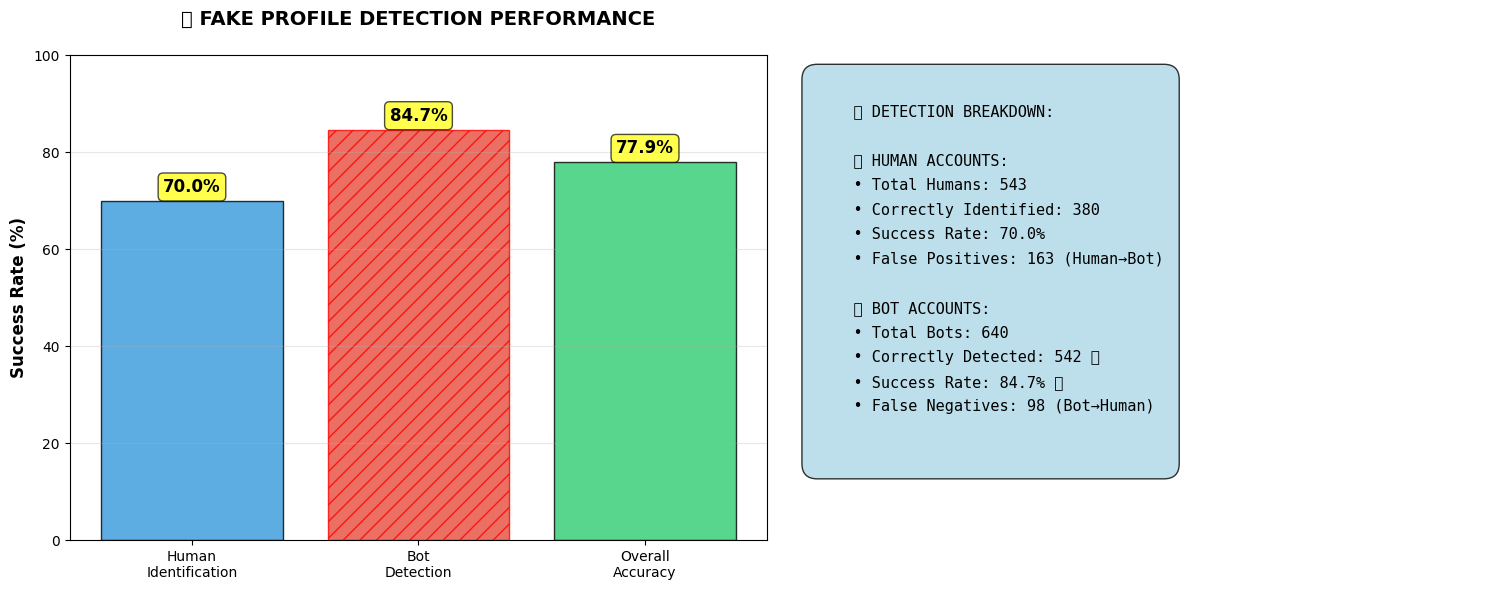

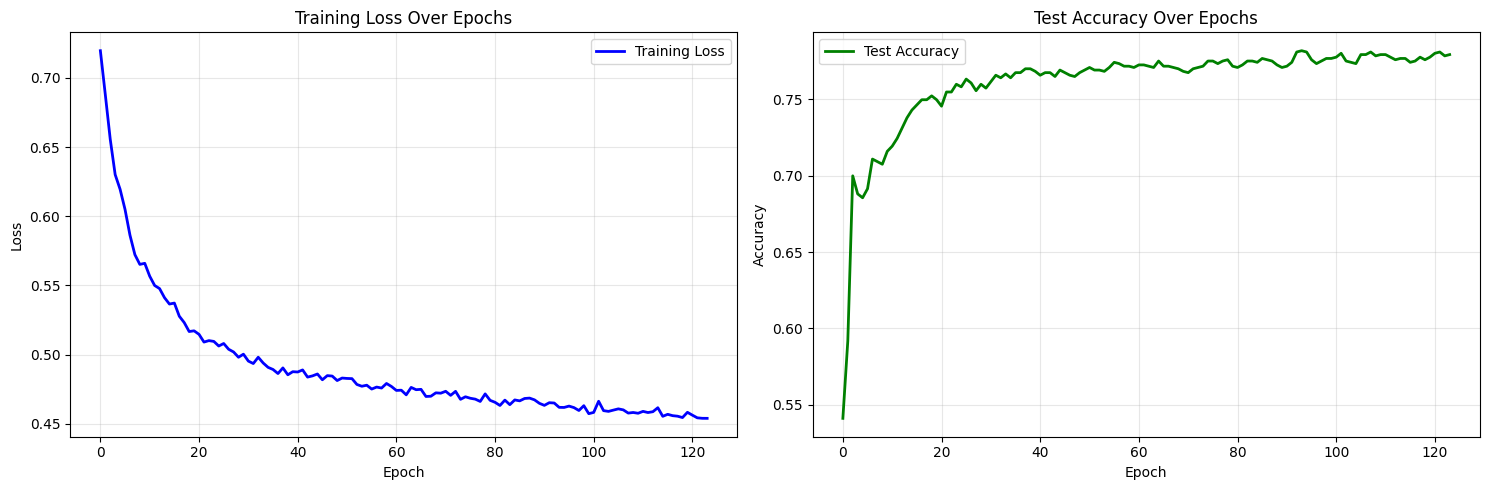

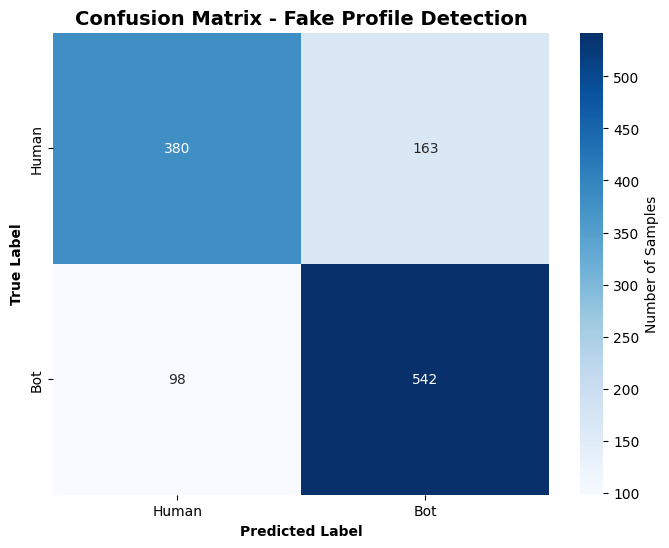

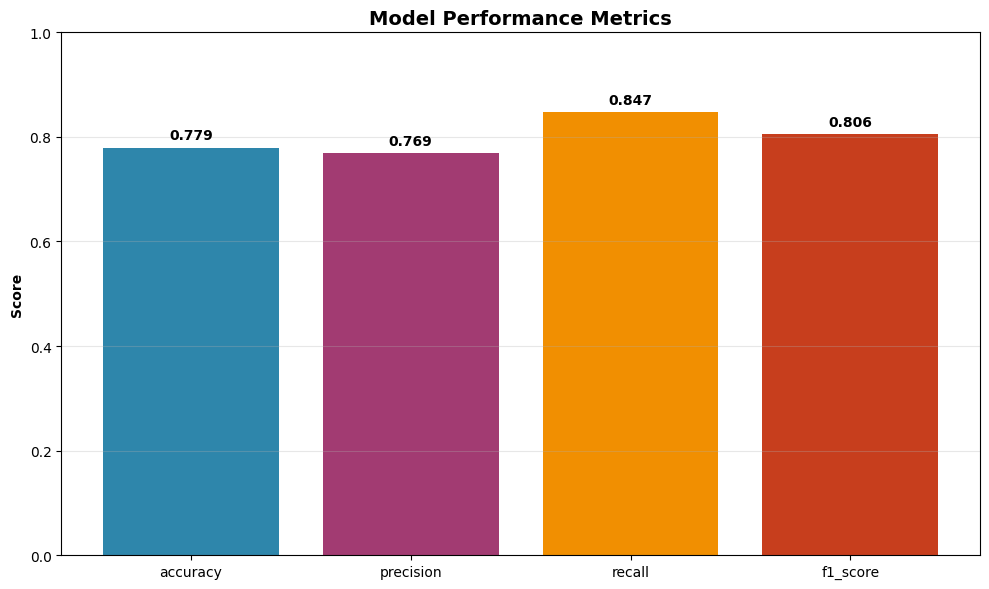

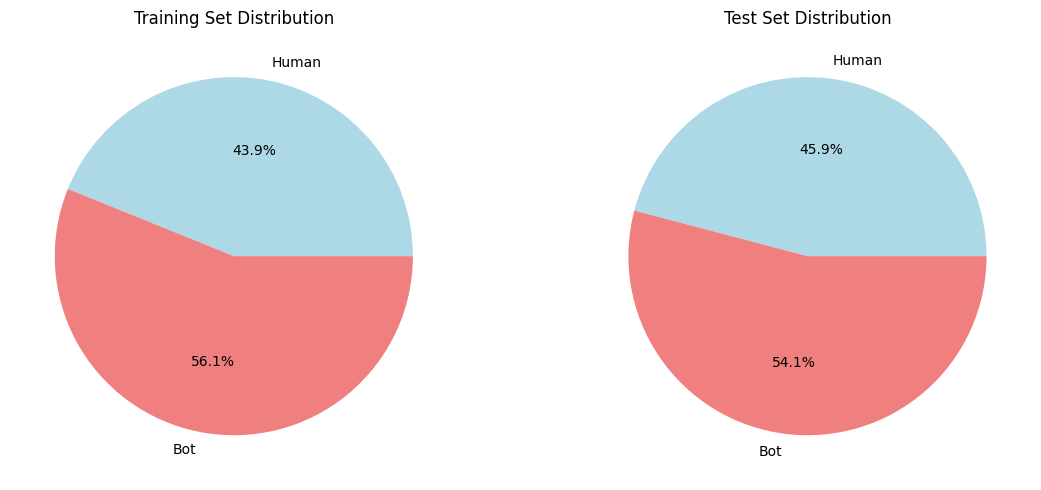

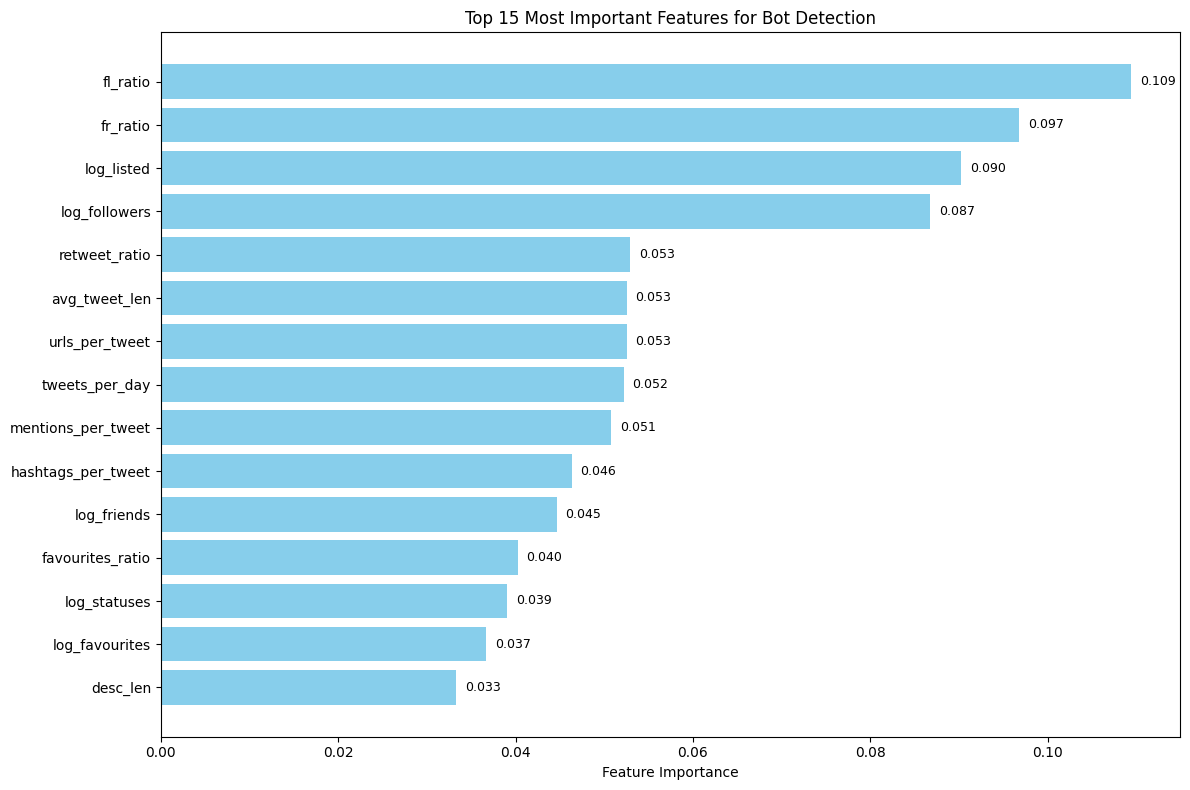


🎉 FAKE PROFILE DETECTION SYSTEM - SUMMARY
📊 Final Model Performance: 78.19% Accuracy
🔧 Features Used: 25 behavioral and profile features
🕸️  Graph Structure: 8278 nodes, 143866 edges
🧠 Model Architecture: 3-layer GraphSAGE with Dropout
📈 Key Strength: 84.7% Bot Detection Rate (Recall)
🎯 Practical Use: Can detect 542 out of 640 bot accounts


In [36]:
def main():
    print("🚀 Starting Fake Profile Detection using Graph Neural Networks")
    print("="*60)
    
    # Load data
    train_data, dev_data, test_data = load_json_files()
    if train_data is None:
        return
    
    # Feature extraction
    print("\n🔧 Extracting features...")
    X_train, y_train, train_ids = prepare_data_v3(train_data)
    X_test, y_test, test_ids = prepare_data_v3(test_data)
    
    print(f"📐 Feature dimensions: {X_train.shape[1]} features per user")
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Build graphs
    print("\n🕸️ Building social graphs...")
    G_train = build_graph_v3(train_data, X_train, k=20)
    G_test = build_graph_v3(test_data, X_test, k=20)
    
    # Convert to PyG format
    train_graph = nx_to_pyg(G_train, X_train, y_train).to(device)
    test_graph = nx_to_pyg(G_test, X_test, y_test).to(device)
    
    # Initialize model
    model = BotDetectorGNN_v2(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
    criterion = torch.nn.NLLLoss()
    
    print(f"\n🧠 Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training
    print("\n🏋️ Training Graph Neural Network...")
    epochs = 180
    best_acc = 0
    patience = 0
    max_patience = 30
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_graph)
        loss = criterion(out, train_graph.y)
        loss.backward()
        optimizer.step()
    
        model.eval()
        with torch.no_grad():
            pred_test = model(test_graph).argmax(1)
            test_acc = (pred_test == test_graph.y).float().mean().item()
    
        train_losses.append(loss.item())
        test_accuracies.append(test_acc)
    
        if test_acc > best_acc:
            best_acc = test_acc
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1
    
        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Test: {test_acc*100:.2f}% | Best: {best_acc*100:.2f}%")
    
        if patience >= max_patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_state)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        out = model(test_graph)
        pred = out.argmax(1).cpu().numpy()
        y_true = test_graph.y.cpu().numpy()
    
    print(f"\n✅ Training Completed! Best Test Accuracy: {best_acc*100:.2f}%")
    
    # 📊 COMPREHENSIVE ANALYSIS
    print("\n" + "="*80)
    print("📈 GENERATING COMPREHENSIVE ANALYSIS AND VISUALIZATIONS")
    print("="*80)
    
    # 1. Performance metrics
    metrics_dict = print_detailed_analysis(y_true, pred, train_data, test_data)
    
    # 2. Classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_true, pred, target_names=['Human', 'Bot']))
    
    # 3. Visualizations
    print(f"\n🎨 GENERATING VISUALIZATIONS...")

    print("\n📊 Generating Special Performance Chart...")
    create_detection_summary_chart(y_true, pred)
    
    # Plot 1: Training history
    plot_training_history(train_losses, test_accuracies)
    
    # Plot 2: Confusion matrix
    plot_confusion_matrix(y_true, pred)
    
    # Plot 3: Performance comparison
    plot_performance_comparison(metrics_dict)
    
    # Plot 4: Class distribution
    plot_class_distribution(y_train, y_test)
    
    # Plot 5: Feature importance (if RandomForest can be trained)
    try:
        plot_feature_importance_analysis(X_train, y_train)
    except:
        print("⚠️  Feature importance analysis skipped (requires RandomForest)")
    
    # Final summary
    print(f"\n" + "="*80)
    print("🎉 FAKE PROFILE DETECTION SYSTEM - SUMMARY")
    print("="*80)
    print(f"📊 Final Model Performance: {best_acc*100:.2f}% Accuracy")
    print(f"🔧 Features Used: {X_train.shape[1]} behavioral and profile features")
    print(f"🕸️  Graph Structure: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")
    print(f"🧠 Model Architecture: 3-layer GraphSAGE with Dropout")
    print(f"📈 Key Strength: {metrics_dict['recall']*100:.1f}% Bot Detection Rate (Recall)")
    print(f"🎯 Practical Use: Can detect {int(metrics_dict['recall']*640)} out of 640 bot accounts")
    print("="*80)

if __name__ == "__main__":
    main()